## What skills are most needed for the top 3 popular data roles?

#### Methodology
1. __Clean Skill Column__: Remove errors and standardize the data.
2. __Count Skills by Job Title__: Find how many times each skill appears for each job title.
3. __Calculate Skill Percentages__: Determine the percentage of each skill for each job title.
4. __Plot Findings__: Visualize the results.

### Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

### Filter Data for the Netherlands

Filter the data for the job market of the Netherlands.

In [2]:
df_NL = df[df['job_country'] == 'Netherlands']

### Explode Skills

Convert the job_skills column from strings to lists. Then, expand these lists so each skill gets its own row. This helps us see the distribution of skills across different job titles by displaying the job_title and job_skills columns.

In [3]:
df_skills = df_NL.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
121,Senior Data Engineer,python
121,Senior Data Engineer,scala
121,Senior Data Engineer,sql
121,Senior Data Engineer,aws
121,Senior Data Engineer,azure
...,...,...
785528,Data Specialist,r
785528,Data Specialist,sql
785528,Data Specialist,azure
785528,Data Specialist,aws


### Count Skills per Job Title

Group the data by job_skills and job_title_short, and count how often each skill appears for each job title. Then, reset the index to convert the Series back into a DataFrame and rename the count column to count. The resulting DataFrame, df_skills_count, shows the frequency of each skill for each job title.

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1075,sql,Data Engineer,3700
844,python,Data Engineer,3613
85,azure,Data Engineer,3245
845,python,Data Scientist,2661
1074,sql,Data Analyst,2075
...,...,...,...
740,ovh,Software Engineer,1
1115,svn,Senior Data Scientist,1
420,graphql,Business Analyst,1
421,graphql,Data Analyst,1


### Create List of Top 3 Roles
Focus on the most popular job titles: Data Analysts, Data Engineers, and Data Scientists. 


Filter the job titles to include only these roles.

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Plot Skill Counts
Create a stacked horizontal bar chart showing the top 5 skills for the top 3 roles, displaying how often each skill appears.

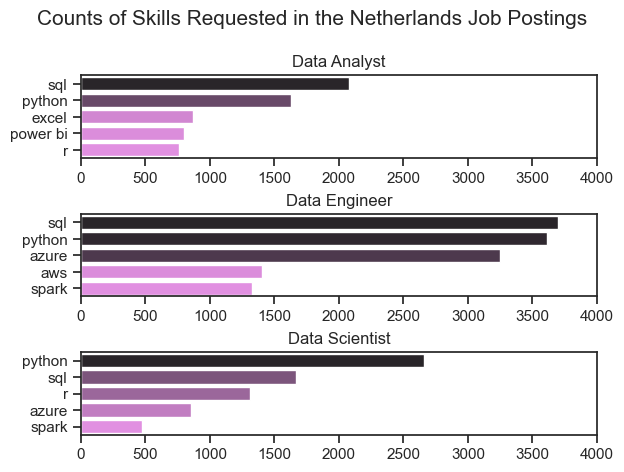

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:violet_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 4000) # make the scales the same

fig.suptitle('Counts of Skills Requested in the Netherlands Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

### Convert Counts to Percentages
Counts alone don’t show the proportion of jobs requesting each skill. To get a clearer picture, we'll convert these counts into percentages.

First, calculate the total number of jobs for each job title. Use the value_counts() method on the job_title_short column to get these totals. Then, reset the index to turn the Series into a DataFrame and rename the columns to job_title_short and jobs_total. The resulting DataFrame, df_job_title_count, will list each job title with its total count.

In [11]:
# Use original df to get the count of job titles
df_job_title_count = df_NL['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,6591
1,Data Scientist,4167
2,Data Analyst,4123
3,Senior Data Engineer,1248
4,Business Analyst,1218
5,Software Engineer,1018
6,Senior Data Scientist,803
7,Senior Data Analyst,511
8,Machine Learning Engineer,492
9,Cloud Engineer,460


### Calculate Percentages
Next, calculate the percentages:

1. __Merge DataFrames__: Combine df_skills_count and df_job_title_count using the job_title_short column. This links each skill count to the total number of job postings for that title.
2. __Compute Percentages__: For each skill, divide the skill count by the total job postings for that title and multiply by 100. Add these percentages as a new column called percentage.

In [12]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,3700,6591,56.137157
1,python,Data Engineer,3613,6591,54.817175
2,azure,Data Engineer,3245,6591,49.233804
3,python,Data Scientist,2661,4167,63.858891
4,sql,Data Analyst,2075,4123,50.327431
...,...,...,...,...,...
1298,ovh,Software Engineer,1,1018,0.098232
1299,svn,Senior Data Scientist,1,803,0.124533
1300,graphql,Business Analyst,1,1218,0.082102
1301,graphql,Data Analyst,1,4123,0.024254


### Plot Percentage Count
Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

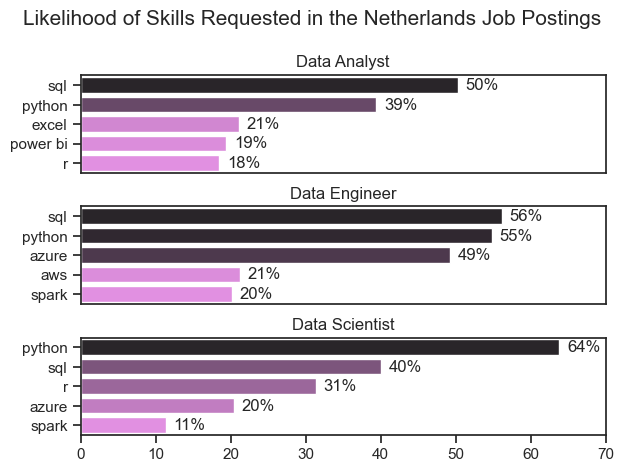

In [15]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:violet_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 70)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in the Netherlands Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()